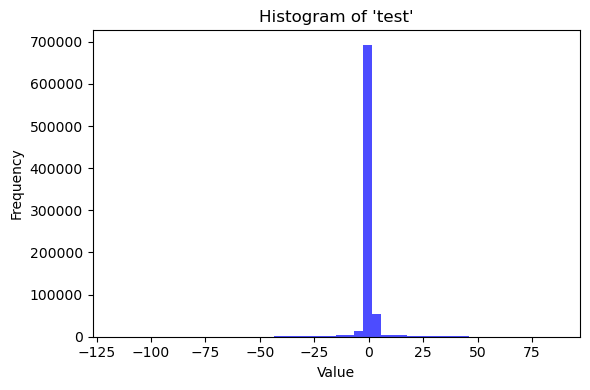

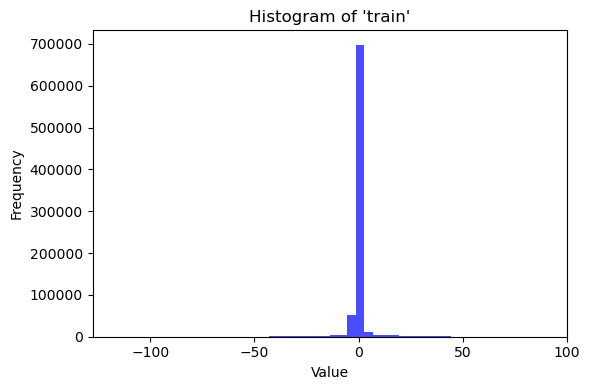

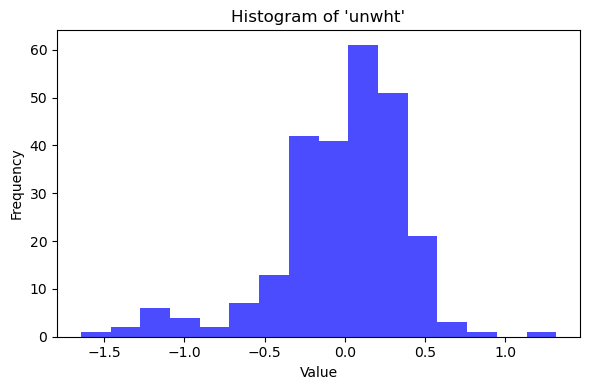

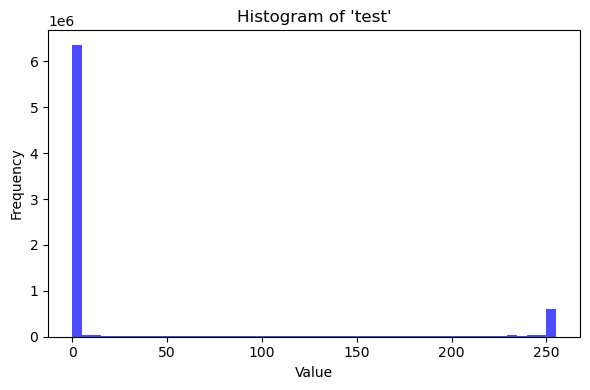

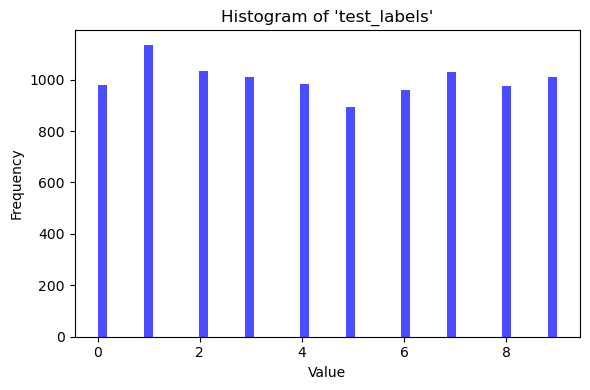

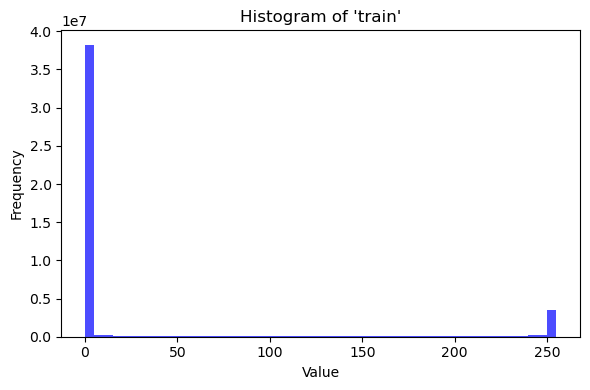

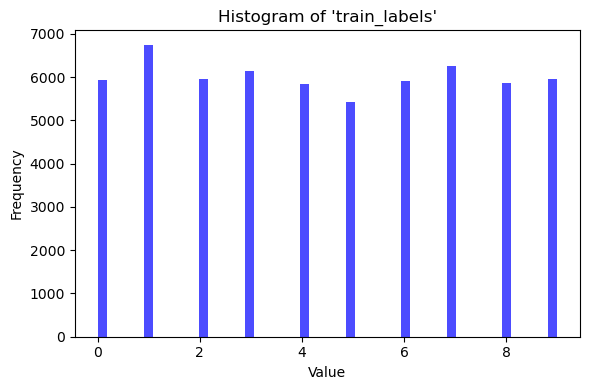

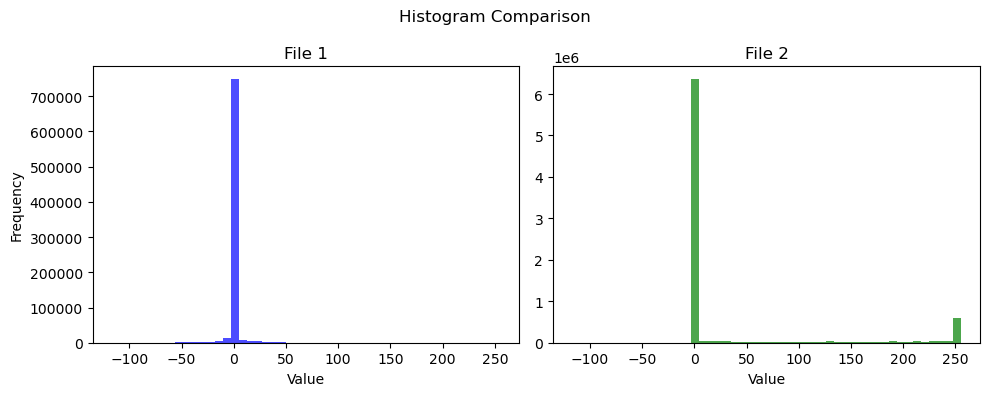

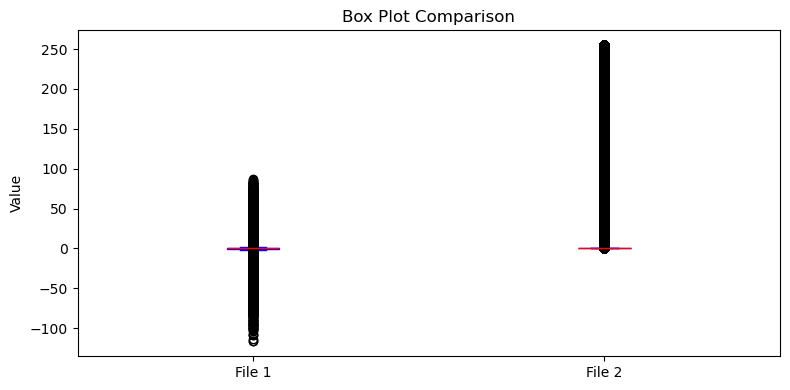

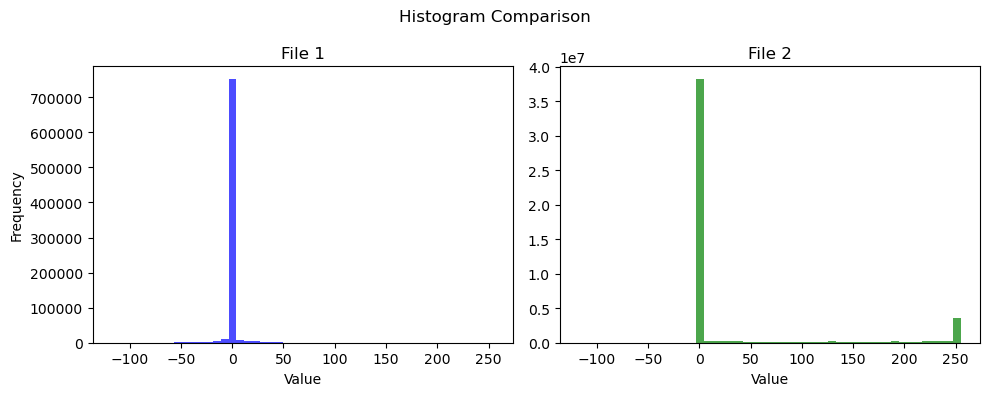

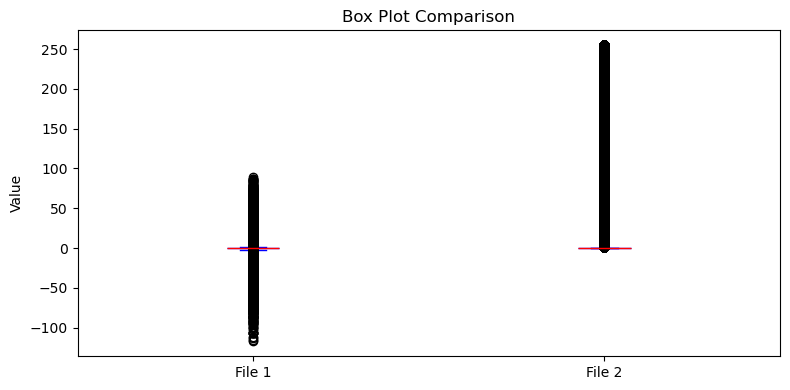

In [4]:
import tkinter as tk  
from tkinter import filedialog, ttk, scrolledtext  
import numpy as np  
import os  
import sys  
import colorsys  
from functools import partial  
import matplotlib.pyplot as plt  
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg  
from scipy import stats  

class NpzComparerApp:  
    def __init__(self, root):  
        self.root = root  
        self.root.title("NPZ File Comparer")  
        self.root.geometry("1200x800")  
        
        # Data storage  
        self.file1_data = None  
        self.file2_data = None  
        self.file1_path = None  
        self.file2_path = None  
        
        # Set icon (optional)  
        try:  
            self.root.iconbitmap(default="")  # You can add an icon file path here  
        except:  
            pass  
            
        # Create main frame  
        main_frame = ttk.Frame(root, padding="10")  
        main_frame.pack(fill=tk.BOTH, expand=True)  
        
        # Create button frame  
        button_frame = ttk.Frame(main_frame)  
        button_frame.pack(fill=tk.X, pady=(0, 10))  
        
        # Add Open File 1 button  
        open_button1 = ttk.Button(button_frame, text="Open File 1", command=lambda: self.open_file(1))  
        open_button1.pack(side=tk.LEFT, padx=(0, 10))  
        
        # Add file 1 path label  
        self.file1_path_var = tk.StringVar()  
        self.file1_path_var.set("No file 1 selected")  
        file1_path_label = ttk.Label(button_frame, textvariable=self.file1_path_var)  
        file1_path_label.pack(side=tk.LEFT, fill=tk.X, expand=True)  
        
        # Add Open File 2 button  
        open_button2 = ttk.Button(button_frame, text="Open File 2", command=lambda: self.open_file(2))  
        open_button2.pack(side=tk.LEFT, padx=(10, 10))  
        
        # Add file 2 path label  
        self.file2_path_var = tk.StringVar()  
        self.file2_path_var.set("No file 2 selected")  
        file2_path_label = ttk.Label(button_frame, textvariable=self.file2_path_var)  
        file2_path_label.pack(side=tk.LEFT, fill=tk.X, expand=True)  
        
        # Add Compare button  
        compare_button = ttk.Button(button_frame, text="Compare Files", command=self.compare_files)  
        compare_button.pack(side=tk.LEFT, padx=(10, 0))  
        
        # Create notebook for tabs  
        self.notebook = ttk.Notebook(main_frame)  
        self.notebook.pack(fill=tk.BOTH, expand=True)  
        
        # Create initial info tab  
        self.info_frame = ttk.Frame(self.notebook)  
        self.notebook.add(self.info_frame, text="Info")  
        
        # Add welcome message  
        welcome_text = scrolledtext.ScrolledText(self.info_frame, wrap=tk.WORD)  
        welcome_text.pack(fill=tk.BOTH, expand=True)  
        welcome_text.insert(tk.END, """  
        Welcome to NPZ File Comparer!  
        
        This application allows you to compare two NumPy .npz files and view their contents.  
        
        Instructions:  
        1. Click "Open File 1" to select the first .npz file  
        2. Click "Open File 2" to select the second .npz file  
        3. Click "Compare Files" to see the differences  
        4. View individual arrays in separate tabs  
        
        Comparison includes:  
        - Missing/extra arrays between files  
        - Differences in array shapes and data types  
        - Numerical differences between corresponding arrays  
        - Statistical analysis (mean, std dev, min, max, percentiles, etc.)  
        - Visual comparison of distributions  
        
        Note: Large arrays will be displayed partially to improve performance.  
        Statistical analyses are performed on the entire dataset.  
        """)  
        welcome_text.config(state=tk.DISABLED)  
        
        # Status bar  
        self.status_var = tk.StringVar()  
        self.status_var.set("Ready")  
        status_bar = ttk.Label(main_frame, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)  
        status_bar.pack(fill=tk.X, side=tk.BOTTOM, pady=(5, 0))  
    
    def open_file(self, file_num):  
        """Open and process a .npz file"""  
        file_path = filedialog.askopenfilename(  
            title=f"Select NPZ File {file_num}",  
            filetypes=[("NumPy Files", "*.npz"), ("All Files", "*.*")]  
        )  
        
        if not file_path:  
            return  
            
        # Update path variable  
        if file_num == 1:  
            self.file1_path = file_path  
            self.file1_path_var.set(os.path.basename(file_path))  
            # Close previous file data if exists  
            if isinstance(self.file1_data, np.lib.npyio.NpzFile):  
                self.file1_data.close()  
            # Load new file  
            self.file1_data = np.load(file_path, allow_pickle=True)  
            self.status_var.set(f"Loaded File 1: {os.path.basename(file_path)}")  
        else:  
            self.file2_path = file_path  
            self.file2_path_var.set(os.path.basename(file_path))  
            # Close previous file data if exists  
            if isinstance(self.file2_data, np.lib.npyio.NpzFile):  
                self.file2_data.close()  
            # Load new file  
            self.file2_data = np.load(file_path, allow_pickle=True)  
            self.status_var.set(f"Loaded File 2: {os.path.basename(file_path)}")  
        
        # Create file tabs  
        self.create_file_tabs(file_num)  
    
    def calculate_statistics(self, arr):  
        """Calculate statistical parameters for a numerical array"""  
        stats_dict = {}  
        
        # Check if array is numeric  
        if not np.issubdtype(arr.dtype, np.number):  
            return None  
        
        # Flatten array for statistics  
        flat_arr = arr.flatten()  
        
        # Filter out NaN values for calculation  
        valid_arr = flat_arr[~np.isnan(flat_arr)]  
        
        # If no valid numbers, return None  
        if len(valid_arr) == 0:  
            return None  
        
        # Calculate basic statistics  
        stats_dict['count'] = len(valid_arr)  
        stats_dict['mean'] = np.mean(valid_arr)  
        stats_dict['std'] = np.std(valid_arr)  
        stats_dict['min'] = np.min(valid_arr)  
        stats_dict['max'] = np.max(valid_arr)  
        stats_dict['range'] = stats_dict['max'] - stats_dict['min']  
        
        # Percentiles  
        stats_dict['25%'] = np.percentile(valid_arr, 25)  
        stats_dict['50%'] = np.percentile(valid_arr, 50)  # median  
        stats_dict['75%'] = np.percentile(valid_arr, 75)  
        stats_dict['iqr'] = stats_dict['75%'] - stats_dict['25%']  # interquartile range  
        
        # Additional statistics  
        stats_dict['variance'] = np.var(valid_arr)  
        stats_dict['skewness'] = stats.skew(valid_arr) if len(valid_arr) > 2 else 0  
        stats_dict['kurtosis'] = stats.kurtosis(valid_arr) if len(valid_arr) > 3 else 0  
        stats_dict['mode'] = stats.mode(valid_arr, keepdims=False)[0] if len(valid_arr) > 0 else 0  
        stats_dict['sum'] = np.sum(valid_arr)  
        stats_dict['abs_sum'] = np.sum(np.abs(valid_arr))  
        stats_dict['rms'] = np.sqrt(np.mean(np.square(valid_arr)))  # root mean square  
        
        # Count zeros, positives, negatives  
        stats_dict['zeros'] = np.sum(valid_arr == 0)  
        stats_dict['positives'] = np.sum(valid_arr > 0)  
        stats_dict['negatives'] = np.sum(valid_arr < 0)  
        
        return stats_dict  
    
    def format_stat_value(self, value):  
        """Format numerical values for display"""  
        if isinstance(value, (int, np.integer)):  
            return f"{value:,}"  
        elif isinstance(value, (float, np.floating)):  
            if abs(value) < 0.001 or abs(value) > 10000:  
                return f"{value:.6e}"  
            else:  
                return f"{value:.6f}"  
        else:  
            return str(value)  
    
    def display_statistics(self, stats_dict, frame):  
        """Display statistics in a scrolled text widget"""  
        if stats_dict is None:  
            ttk.Label(frame, text="Not a numerical array or no valid data for statistics.").pack(anchor=tk.W, padx=5, pady=5)  
            return  
        
        # Create a tree view for statistics  
        tree = ttk.Treeview(frame, columns=("statistic", "value"))  
        tree.heading("statistic", text="Statistic")  
        tree.heading("value", text="Value")  
        tree.column("#0", width=0, stretch=tk.NO)  
        tree.column("statistic", width=150, anchor=tk.W)  
        tree.column("value", width=250, anchor=tk.E)  
        
        # Add scrollbar  
        y_scroll = ttk.Scrollbar(frame, orient=tk.VERTICAL, command=tree.yview)  
        tree.configure(yscrollcommand=y_scroll.set)  
        
        # Pack widgets  
        tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)  
        y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
        
        # Add stats to tree  
        sections = {  
            "Basic Statistics": ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "range"],  
            "Distribution": ["variance", "skewness", "kurtosis", "iqr", "mode"],  
            "Aggregation": ["sum", "abs_sum", "rms"],  
            "Counts": ["zeros", "positives", "negatives"]  
        }  
        
        for section, keys in sections.items():  
            section_id = tree.insert("", tk.END, text=section, values=(section, ""))  
            for key in keys:  
                if key in stats_dict:  
                    tree.insert(section_id, tk.END, values=(key, self.format_stat_value(stats_dict[key])))  
    
    def create_histogram(self, arr1, arr2, title1, title2, frame):  
        """Create a histogram comparison of two arrays"""  
        if arr1 is None or arr2 is None:  
            ttk.Label(frame, text="Cannot create histogram: Missing data").pack(anchor=tk.CENTER)  
            return  
            
        # Check if arrays are numerical  
        if not (np.issubdtype(arr1.dtype, np.number) and np.issubdtype(arr2.dtype, np.number)):  
            ttk.Label(frame, text="Cannot create histogram: Non-numerical data").pack(anchor=tk.CENTER)  
            return  
            
        # Flatten arrays  
        flat1 = arr1.flatten()  
        flat2 = arr2.flatten()  
        
        # Remove NaNs  
        valid1 = flat1[~np.isnan(flat1)]  
        valid2 = flat2[~np.isnan(flat2)]  
        
        if len(valid1) == 0 or len(valid2) == 0:  
            ttk.Label(frame, text="Cannot create histogram: No valid data after removing NaNs").pack(anchor=tk.CENTER)  
            return  
            
        # Create figure and axis  
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  
        fig.suptitle(f"Histogram Comparison")  
        
        # Determine bin range (use the same for both histograms)  
        all_data = np.concatenate([valid1, valid2])  
        min_val, max_val = np.min(all_data), np.max(all_data)  
        
        # Account for identical values  
        if min_val == max_val:  
            min_val -= 0.5  
            max_val += 0.5  
        
        bins = np.linspace(min_val, max_val, min(50, int(np.sqrt(len(all_data)))))  
        
        # Create histograms  
        ax1.hist(valid1, bins=bins, alpha=0.7, color='blue')  
        ax1.set_title(title1)  
        ax1.set_xlabel('Value')  
        ax1.set_ylabel('Frequency')  
        
        ax2.hist(valid2, bins=bins, alpha=0.7, color='green')  
        ax2.set_title(title2)  
        ax2.set_xlabel('Value')  
        
        # Adjust layout  
        plt.tight_layout()  
        
        # Create canvas  
        canvas = FigureCanvasTkAgg(fig, master=frame)  
        canvas.draw()  
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)  
    
    def create_box_plot(self, arr1, arr2, title1, title2, frame):  
        """Create box plots for two arrays"""  
        if arr1 is None or arr2 is None:  
            ttk.Label(frame, text="Cannot create box plot: Missing data").pack(anchor=tk.CENTER)  
            return  
            
        # Check if arrays are numerical  
        if not (np.issubdtype(arr1.dtype, np.number) and np.issubdtype(arr2.dtype, np.number)):  
            ttk.Label(frame, text="Cannot create box plot: Non-numerical data").pack(anchor=tk.CENTER)  
            return  
            
        # Flatten arrays  
        flat1 = arr1.flatten()  
        flat2 = arr2.flatten()  
        
        # Remove NaNs  
        valid1 = flat1[~np.isnan(flat1)]  
        valid2 = flat2[~np.isnan(flat2)]  
        
        if len(valid1) == 0 or len(valid2) == 0:  
            ttk.Label(frame, text="Cannot create box plot: No valid data after removing NaNs").pack(anchor=tk.CENTER)  
            return  
            
        # Create figure  
        fig, ax = plt.subplots(figsize=(8, 4))  
        
        # Create box plots  
        box_data = [valid1, valid2]  
        ax.boxplot(box_data, labels=[title1, title2], patch_artist=True,  
                   boxprops=dict(facecolor='lightblue', color='blue'),  
                   whiskerprops=dict(color='blue'),  
                   capprops=dict(color='blue'),  
                   medianprops=dict(color='red'))  
        
        ax.set_title("Box Plot Comparison")  
        ax.set_ylabel("Value")  
        
        # Adjust layout  
        plt.tight_layout()  
        
        # Create canvas  
        canvas = FigureCanvasTkAgg(fig, master=frame)  
        canvas.draw()  
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)  
    
    def create_file_tabs(self, file_num):  
        """Create tabs for the loaded file"""  
        # Get the data and tab prefix  
        if file_num == 1:  
            npz_data = self.file1_data  
            tab_prefix = "F1: "  
        else:  
            npz_data = self.file2_data  
            tab_prefix = "F2: "  
        
        if npz_data is None:  
            return  
        
        # Get array keys  
        array_keys = list(npz_data.keys())  
        
        if not array_keys:  
            self.status_var.set(f"No arrays found in File {file_num}.")  
            return  
        
        # Create summary tab for this file  
        summary_tab_name = f"{tab_prefix}Summary"  
        
        # Check if the tab already exists  
        for tab_id in self.notebook.tabs():  
            if self.notebook.tab(tab_id, "text") == summary_tab_name:  
                self.notebook.forget(tab_id)  
                break  
        
        summary_frame = ttk.Frame(self.notebook)  
        self.notebook.add(summary_frame, text=summary_tab_name)  
        
        # Create summary tree  
        summary_tree = ttk.Treeview(summary_frame, columns=("name", "shape", "dtype", "dims", "size", "memory", "mean", "std", "min", "max"))  
        summary_tree.heading("#0", text="")  
        summary_tree.heading("name", text="Array Name")  
        summary_tree.heading("shape", text="Shape")  
        summary_tree.heading("dtype", text="Data Type")  
        summary_tree.heading("dims", text="Dims")  
        summary_tree.heading("size", text="Size")  
        summary_tree.heading("memory", text="Memory")  
        summary_tree.heading("mean", text="Mean")  
        summary_tree.heading("std", text="Std Dev")  
        summary_tree.heading("min", text="Min")  
        summary_tree.heading("max", text="Max")  
        
        summary_tree.column("#0", width=0, stretch=tk.NO)  
        summary_tree.column("name", width=120, anchor=tk.W)  
        summary_tree.column("shape", width=100, anchor=tk.W)  
        summary_tree.column("dtype", width=80, anchor=tk.W)  
        summary_tree.column("dims", width=40, anchor=tk.CENTER)  
        summary_tree.column("size", width=80, anchor=tk.E)  
        summary_tree.column("memory", width=80, anchor=tk.E)  
        summary_tree.column("mean", width=100, anchor=tk.E)  
        summary_tree.column("std", width=100, anchor=tk.E)  
        summary_tree.column("min", width=100, anchor=tk.E)  
        summary_tree.column("max", width=100, anchor=tk.E)  
        
        # Add scrollbars  
        summary_y_scroll = ttk.Scrollbar(summary_frame, orient=tk.VERTICAL, command=summary_tree.yview)  
        summary_x_scroll = ttk.Scrollbar(summary_frame, orient=tk.HORIZONTAL, command=summary_tree.xview)  
        summary_tree.configure(yscrollcommand=summary_y_scroll.set, xscrollcommand=summary_x_scroll.set)  
        
        # Pack summary tree  
        summary_tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True)  
        summary_x_scroll.pack(side=tk.BOTTOM, fill=tk.X)  
        summary_y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
        
        # Add summary data  
        for key in array_keys:  
            arr = npz_data[key]  
            
            # Try to calculate statistics  
            stats_dict = self.calculate_statistics(arr)  
            
            # Prepare mean, std, min, max values  
            if stats_dict:  
                mean_val = self.format_stat_value(stats_dict['mean'])  
                std_val = self.format_stat_value(stats_dict['std'])   
                min_val = self.format_stat_value(stats_dict['min'])  
                max_val = self.format_stat_value(stats_dict['max'])  
            else:  
                mean_val = "N/A"  
                std_val = "N/A"  
                min_val = "N/A"  
                max_val = "N/A"  
                
            summary_tree.insert(  
                "",   
                tk.END,   
                values=(  
                    key,  
                    str(arr.shape),  
                    str(arr.dtype),  
                    arr.ndim,  
                    f"{arr.size:,}",  
                    f"{arr.nbytes / (1024**2):.2f} MB",  
                    mean_val,  
                    std_val,  
                    min_val,  
                    max_val  
                )  
            )  
        
        # Create array tabs for this file  
        for key in array_keys:  
            array_tab_name = f"{tab_prefix}{key}"  
            
            # Check if the tab already exists  
            for tab_id in self.notebook.tabs():  
                if self.notebook.tab(tab_id, "text") == array_tab_name:  
                    self.notebook.forget(tab_id)  
                    break  
            
            arr = npz_data[key]  
            array_frame = ttk.Frame(self.notebook)  
            self.notebook.add(array_frame, text=array_tab_name)  
            
            # Create a notebook for array data and statistics  
            arr_notebook = ttk.Notebook(array_frame)  
            arr_notebook.pack(fill=tk.BOTH, expand=True)  
            
            # Data tab  
            data_frame = ttk.Frame(arr_notebook)  
            arr_notebook.add(data_frame, text="Data")  
            
            # Create info label  
            info_text = f"Array: '{key}'\nShape: {arr.shape}\nDimensions: {arr.ndim}\nData Type: {arr.dtype}\nSize: {arr.size:,} elements\nMemory: {arr.nbytes / (1024**2):.2f} MB"  
            info_label = ttk.Label(data_frame, text=info_text, justify=tk.LEFT)  
            info_label.pack(anchor=tk.W, pady=(5, 10))  
            
            # Create data display frame  
            data_display_frame = ttk.Frame(data_frame)  
            data_display_frame.pack(fill=tk.BOTH, expand=True)  
            
            # Handle array display based on dimensions  
            if arr.ndim == 1:  
                # 1D array - show as single column  
                self.display_1d_array(arr, key, data_display_frame)  
            elif arr.ndim == 2:  
                # 2D array - show as grid  
                self.display_2d_array(arr, data_display_frame)  
            else:  
                # Higher dimensional arrays - show preview  
                self.display_nd_array(arr, data_display_frame)  
                
            # Statistics tab (only for numerical arrays)  
            if np.issubdtype(arr.dtype, np.number):  
                stats_frame = ttk.Frame(arr_notebook)  
                arr_notebook.add(stats_frame, text="Statistics")  
                
                # Create paned window for statistics and visualization  
                stats_paned = ttk.PanedWindow(stats_frame, orient=tk.HORIZONTAL)  
                stats_paned.pack(fill=tk.BOTH, expand=True)  
                
                # Left panel for statistics  
                left_panel = ttk.Frame(stats_paned)  
                stats_paned.add(left_panel, weight=1)  
                
                # Calculate and display statistics  
                stats_dict = self.calculate_statistics(arr)  
                self.display_statistics(stats_dict, left_panel)  
                
                # Right panel for visualizations  
                right_panel = ttk.Frame(stats_paned)  
                stats_paned.add(right_panel, weight=2)  
                
                # Visualization notebook  
                viz_notebook = ttk.Notebook(right_panel)  
                viz_notebook.pack(fill=tk.BOTH, expand=True)  
                
                # Histogram tab  
                hist_frame = ttk.Frame(viz_notebook)  
                viz_notebook.add(hist_frame, text="Histogram")  
                
                if arr.size > 0 and np.issubdtype(arr.dtype, np.number):  
                    if len(arr.flatten()[~np.isnan(arr.flatten())]) > 0:  
                        # Create a simple histogram  
                        fig, ax = plt.subplots(figsize=(6, 4))  
                        valid_data = arr.flatten()[~np.isnan(arr.flatten())]  
                        
                        if len(valid_data) > 0:  
                            n_bins = min(50, int(np.sqrt(len(valid_data))))  
                            ax.hist(valid_data, bins=n_bins, alpha=0.7, color='blue')  
                            ax.set_title(f"Histogram of '{key}'")  
                            ax.set_xlabel("Value")  
                            ax.set_ylabel("Frequency")  
                            plt.tight_layout()  
                            
                            canvas = FigureCanvasTkAgg(fig, master=hist_frame)  
                            canvas.draw()  
                            canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)  
                        else:  
                            ttk.Label(hist_frame, text="No valid data for histogram").pack(anchor=tk.CENTER)  
                    else:  
                        ttk.Label(hist_frame, text="No valid data for histogram").pack(anchor=tk.CENTER)  
                else:  
                    ttk.Label(hist_frame, text="Cannot create histogram for this data type").pack(anchor=tk.CENTER)  
        
        # Switch to the summary tab for this file  
        for i, tab_id in enumerate(self.notebook.tabs()):  
            if self.notebook.tab(tab_id, "text") == summary_tab_name:  
                self.notebook.select(i)  
                break  
    
    def compare_files(self):  
        """Compare the two loaded .npz files"""  
        if self.file1_data is None or self.file2_data is None:  
            self.status_var.set("Please load both files before comparing.")  
            return  
        
        # Get keys from both files  
        keys1 = set(self.file1_data.keys())  
        keys2 = set(self.file2_data.keys())  
        
        # Create the comparison tab  
        comparison_tab_name = "Comparison Results"  
        
        # Check if the tab already exists  
        for tab_id in self.notebook.tabs():  
            if self.notebook.tab(tab_id, "text") == comparison_tab_name:  
                self.notebook.forget(tab_id)  
                break  
        
        comparison_frame = ttk.Frame(self.notebook)  
        self.notebook.add(comparison_frame, text=comparison_tab_name)  
        
        # Create comparison results text widget  
        comparison_text = scrolledtext.ScrolledText(comparison_frame, wrap=tk.WORD, height=10)  
        comparison_text.pack(fill=tk.X, expand=False, pady=(0, 10))  
        
        # Add header  
        comparison_text.insert(tk.END, f"Comparison between:\n")  
        comparison_text.insert(tk.END, f"File 1: {self.file1_path}\n")  
        comparison_text.insert(tk.END, f"File 2: {self.file2_path}\n\n")  
        
        # Check for different keys  
        only_in_file1 = keys1 - keys2  
        only_in_file2 = keys2 - keys1  
        common_keys = keys1.intersection(keys2)  
        
        comparison_text.insert(tk.END, f"File 1 has {len(keys1)} arrays. File 2 has {len(keys2)} arrays.\n")  
        comparison_text.insert(tk.END, f"Arrays only in File 1: {len(only_in_file1)}\n")  
        comparison_text.insert(tk.END, f"Arrays only in File 2: {len(only_in_file2)}\n")  
        comparison_text.insert(tk.END, f"Common arrays: {len(common_keys)}\n\n")  
        
        if only_in_file1:  
            comparison_text.insert(tk.END, "Arrays only in File 1:\n")  
            for key in sorted(only_in_file1):  
                comparison_text.insert(tk.END, f"  - {key}\n")  
            comparison_text.insert(tk.END, "\n")  
        
        if only_in_file2:  
            comparison_text.insert(tk.END, "Arrays only in File 2:\n")  
            for key in sorted(only_in_file2):  
                comparison_text.insert(tk.END, f"  - {key}\n")  
            comparison_text.insert(tk.END, "\n")  
        
        # Create a notebook for comparison details  
        comp_notebook = ttk.Notebook(comparison_frame)  
        comp_notebook.pack(fill=tk.BOTH, expand=True)  
        
        # Basic comparison tab  
        basic_frame = ttk.Frame(comp_notebook)  
        comp_notebook.add(basic_frame, text="Basic Comparison")  
        
        # Create a tree view for detailed array comparisons  
        details_tree = ttk.Treeview(basic_frame, columns=("name", "shape1", "shape2", "dtype1", "dtype2", "status"))  
        details_tree.heading("#0", text="")  
        details_tree.heading("name", text="Array Name")  
        details_tree.heading("shape1", text="Shape (File 1)")  
        details_tree.heading("shape2", text="Shape (File 2)")  
        details_tree.heading("dtype1", text="Dtype (File 1)")  
        details_tree.heading("dtype2", text="Dtype (File 2)")  
        details_tree.heading("status", text="Status")  
        
        details_tree.column("#0", width=0, stretch=tk.NO)  
        details_tree.column("name", width=150, anchor=tk.W)  
        details_tree.column("shape1", width=150, anchor=tk.W)  
        details_tree.column("shape2", width=150, anchor=tk.W)  
        details_tree.column("dtype1", width=100, anchor=tk.W)  
        details_tree.column("dtype2", width=100, anchor=tk.W)  
        details_tree.column("status", width=200, anchor=tk.W)  
        
        # Add scrollbars  
        details_y_scroll = ttk.Scrollbar(basic_frame, orient=tk.VERTICAL, command=details_tree.yview)  
        details_x_scroll = ttk.Scrollbar(basic_frame, orient=tk.HORIZONTAL, command=details_tree.xview)  
        details_tree.configure(yscrollcommand=details_y_scroll.set, xscrollcommand=details_x_scroll.set)  
        
        # Pack details tree  
        details_tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True)  
        details_x_scroll.pack(side=tk.BOTTOM, fill=tk.X)  
        details_y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
        
        # Define a tag for different arrays  
        details_tree.tag_configure("different", background="#ffcccc")  
        details_tree.tag_configure("identical", background="#ccffcc")  
        details_tree.tag_configure("missing", background="#ccccff")  
        
        # Add details for arrays only in file 1  
        for key in sorted(only_in_file1):  
            arr = self.file1_data[key]  
            details_tree.insert(  
                "",   
                tk.END,   
                values=(  
                    key,  
                    str(arr.shape),  
                    "N/A",  
                    str(arr.dtype),  
                    "N/A",  
                    "Only in File 1"  
                ),  
                tags=("missing",)  
            )  
        
        # Add details for arrays only in file 2  
        for key in sorted(only_in_file2):  
            arr = self.file2_data[key]  
            details_tree.insert(  
                "",   
                tk.END,   
                values=(  
                    key,  
                    "N/A",  
                    str(arr.shape),  
                    "N/A",  
                    str(arr.dtype),  
                    "Only in File 2"  
                ),  
                tags=("missing",)  
            )  
        
        # Statistical comparison tab  
        stats_frame = ttk.Frame(comp_notebook)  
        comp_notebook.add(stats_frame, text="Statistical Comparison")  
        
        # Create a tree view for statistical comparisons  
        stats_tree = ttk.Treeview(stats_frame, columns=("name", "mean1", "mean2", "std1", "std2", "min1", "min2", "max1", "max2", "diff"))  
        stats_tree.heading("#0", text="")  
        stats_tree.heading("name", text="Array Name")  
        stats_tree.heading("mean1", text="Mean (F1)")  
        stats_tree.heading("mean2", text="Mean (F2)")  
        stats_tree.heading("std1", text="Std (F1)")  
        stats_tree.heading("std2", text="Std (F2)")  
        stats_tree.heading("min1", text="Min (F1)")  
        stats_tree.heading("min2", text="Min (F2)")  
        stats_tree.heading("max1", text="Max (F1)")  
        stats_tree.heading("max2", text="Max (F2)")  
        stats_tree.heading("diff", text="Diff %")  
        
        stats_tree.column("#0", width=0, stretch=tk.NO)  
        stats_tree.column("name", width=100, anchor=tk.W)  
        stats_tree.column("mean1", width=90, anchor=tk.E)  
        stats_tree.column("mean2", width=90, anchor=tk.E)  
        stats_tree.column("std1", width=90, anchor=tk.E)  
        stats_tree.column("std2", width=90, anchor=tk.E)  
        stats_tree.column("min1", width=90, anchor=tk.E)  
        stats_tree.column("min2", width=90, anchor=tk.E)  
        stats_tree.column("max1", width=90, anchor=tk.E)  
        stats_tree.column("max2", width=90, anchor=tk.E)  
        stats_tree.column("diff", width=90, anchor=tk.E)  
        
        # Add scrollbars  
        stats_y_scroll = ttk.Scrollbar(stats_frame, orient=tk.VERTICAL, command=stats_tree.yview)  
        stats_x_scroll = ttk.Scrollbar(stats_frame, orient=tk.HORIZONTAL, command=stats_tree.xview)  
        stats_tree.configure(yscrollcommand=stats_y_scroll.set, xscrollcommand=stats_x_scroll.set)  
        
        # Pack stats tree  
        stats_tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True)  
        stats_x_scroll.pack(side=tk.BOTTOM, fill=tk.X)  
        stats_y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
        
        # Define tags for different levels of difference  
        stats_tree.tag_configure("high_diff", background="#ff9999")  # Red for big differences  
        stats_tree.tag_configure("med_diff", background="#ffcc99")   # Orange for medium differences  
        stats_tree.tag_configure("low_diff", background="#ffffcc")   # Yellow for small differences  
        stats_tree.tag_configure("no_diff", background="#ccffcc")    # Green for no differences  
        stats_tree.tag_configure("non_numeric", background="#e6e6e6") # Gray for non-numeric arrays  
        
        # Compare common arrays  
        if common_keys:  
            comparison_text.insert(tk.END, "Differences in common arrays:\n")  
            difference_count = 0  
            
            for key in sorted(common_keys):  
                arr1 = self.file1_data[key]  
                arr2 = self.file2_data[key]  
                
                status = []  
                is_different = False  
                
                # Check shape  
                if arr1.shape != arr2.shape:  
                    status.append("Different shapes")  
                    is_different = True  
                
                # Check dtype  
                if arr1.dtype != arr2.dtype:  
                    status.append("Different dtypes")  
                    is_different = True  
                
                # Check values for arrays with same shape and dtype  
                if not is_different:  
                    # For numerical arrays, check if they are close  
                    if np.issubdtype(arr1.dtype, np.number):  
                        try:  
                            # Only check if shapes match  
                            if arr1.shape == arr2.shape:  
                                # For large arrays, check in chunks or just a sample  
                                if arr1.size > 1000000:  # Arbitrary threshold for "large"  
                                    # Sample comparison for large arrays  
                                    indices = np.random.choice(arr1.size, min(100000, arr1.size), replace=False)  
                                    flat1 = arr1.flat[indices]  
                                    flat2 = arr2.flat[indices]  
                                    if not np.allclose(flat1, flat2, rtol=1e-5, atol=1e-8, equal_nan=True):  
                                        status.append("Numerical differences (sampled)")  
                                        is_different = True  
                                else:  
                                    # Full comparison for smaller arrays  
                                    if not np.allclose(arr1, arr2, rtol=1e-5, atol=1e-8, equal_nan=True):  
                                        status.append("Numerical differences")  
                                        is_different = True  
                        except Exception as e:  
                            status.append(f"Error comparing values: {str(e)}")  
                            is_different = True  
                    else:  
                        # For non-numerical arrays  
                        try:  
                            if not np.array_equal(arr1, arr2):  
                                status.append("Data differences")  
                                is_different = True  
                        except Exception as e:  
                            status.append(f"Error comparing values: {str(e)}")  
                            is_different = True  
                
                status_text = ", ".join(status) if status else "Identical"  
                
                # Add to basic comparison tree view  
                details_tree.insert(  
                    "",   
                    tk.END,   
                    values=(  
                        key,  
                        str(arr1.shape),  
                        str(arr2.shape),  
                        str(arr1.dtype),  
                        str(arr2.dtype),  
                        status_text  
                    ),  
                    tags=("different" if is_different else "identical",)  
                )  
                
                # Add to text summary if different  
                if is_different:  
                    difference_count += 1  
                    comparison_text.insert(tk.END, f"  - {key}: {status_text}\n")  
                
                # Add statistical comparison if both are numerical arrays  
                if (np.issubdtype(arr1.dtype, np.number) and np.issubdtype(arr2.dtype, np.number)):  
                    stats1 = self.calculate_statistics(arr1)  
                    stats2 = self.calculate_statistics(arr2)  
                    
                    if stats1 and stats2:  
                        # Calculate mean difference percentage  
                        if abs(stats1['mean']) > 1e-10 or abs(stats2['mean']) > 1e-10:  
                            # Avoid division by zero  
                            mean_avg = (abs(stats1['mean']) + abs(stats2['mean'])) / 2  
                            if mean_avg > 0:  
                                mean_diff_pct = 100 * abs(stats1['mean'] - stats2['mean']) / mean_avg  
                            else:  
                                mean_diff_pct = 0  
                        else:  
                            mean_diff_pct = 0  
                            
                        # Determine difference level tag  
                        if mean_diff_pct > 10:  # More than 10% difference  
                            diff_tag = "high_diff"  
                        elif mean_diff_pct > 5:  # 5-10% difference  
                            diff_tag = "med_diff"  
                        elif mean_diff_pct > 1:  # 1-5% difference  
                            diff_tag = "low_diff"  
                        else:  
                            diff_tag = "no_diff"  
                            
                        # Format values for display  
                        mean1 = self.format_stat_value(stats1['mean'])  
                        mean2 = self.format_stat_value(stats2['mean'])  
                        std1 = self.format_stat_value(stats1['std'])  
                        std2 = self.format_stat_value(stats2['std'])  
                        min1 = self.format_stat_value(stats1['min'])  
                        min2 = self.format_stat_value(stats2['min'])  
                        max1 = self.format_stat_value(stats1['max'])  
                        max2 = self.format_stat_value(stats2['max'])  
                        
                        stats_tree.insert(  
                            "",   
                            tk.END,   
                            values=(  
                                key,  
                                mean1,  
                                mean2,  
                                std1,  
                                std2,  
                                min1,  
                                min2,  
                                max1,  
                                max2,  
                                f"{mean_diff_pct:.2f}%"  
                            ),  
                            tags=(diff_tag,)  
                        )  
                    else:  
                        # Handle case where statistics couldn't be calculated  
                        stats_tree.insert(  
                            "",  
                            tk.END,  
                            values=(key, "Error", "Error", "Error", "Error", "Error", "Error", "Error", "Error", "N/A"),  
                            tags=("non_numeric",)  
                        )  
                else:  
                    # Non-numeric arrays  
                    stats_tree.insert(  
                        "",  
                        tk.END,  
                        values=(key, "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A"),  
                        tags=("non_numeric",)  
                    )  
            
            if difference_count == 0:  
                comparison_text.insert(tk.END, "  No differences found in common arrays.\n")  
            else:  
                comparison_text.insert(tk.END, f"  Found differences in {difference_count} of {len(common_keys)} common arrays.\n")  
        
        # Create comparison tabs for common arrays  
        for key in sorted(common_keys):  
            self.create_comparison_tab(key)  
        
        # Make the text read-only  
        comparison_text.config(state=tk.DISABLED)  
        
        # Switch to the comparison tab  
        for i, tab_id in enumerate(self.notebook.tabs()):  
            if self.notebook.tab(tab_id, "text") == comparison_tab_name:  
                self.notebook.select(i)  
                break  
                
        self.status_var.set("Comparison completed.")  
    
    def create_comparison_tab(self, array_key):  
        """Create a tab comparing a specific array between both files"""  
        if array_key not in self.file1_data or array_key not in self.file2_data:  
            return  
            
        tab_name = f"Compare: {array_key}"  
        
        # Check if the tab already exists  
        for tab_id in self.notebook.tabs():  
            if self.notebook.tab(tab_id, "text") == tab_name:  
                self.notebook.forget(tab_id)  
                break  
        
        arr1 = self.file1_data[array_key]  
        arr2 = self.file2_data[array_key]  
        
        # Create the tab  
        compare_frame = ttk.Frame(self.notebook)  
        self.notebook.add(compare_frame, text=tab_name)  
        
        # Create notebook for comparison tabs  
        compare_notebook = ttk.Notebook(compare_frame)  
        compare_notebook.pack(fill=tk.BOTH, expand=True)  
        
        # Overview tab  
        overview_frame = ttk.Frame(compare_notebook)  
        compare_notebook.add(overview_frame, text="Overview")  
        
        # Create info section  
        info_frame = ttk.Frame(overview_frame)  
        info_frame.pack(fill=tk.X, pady=(0, 10))  
        
        # File 1 info  
        file1_info = ttk.LabelFrame(info_frame, text="File 1")  
        file1_info.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 5))  
        
        file1_text = f"Shape: {arr1.shape}\nDtype: {arr1.dtype}\nSize: {arr1.size:,} elements"  
        ttk.Label(file1_info, text=file1_text, justify=tk.LEFT).pack(anchor=tk.W, padx=5, pady=5)  
        
        # File 2 info  
        file2_info = ttk.LabelFrame(info_frame, text="File 2")  
        file2_info.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(5, 0))  
        
        file2_text = f"Shape: {arr2.shape}\nDtype: {arr2.dtype}\nSize: {arr2.size:,} elements"  
        ttk.Label(file2_info, text=file2_text, justify=tk.LEFT).pack(anchor=tk.W, padx=5, pady=5)  
        
        # Comparison results  
        comparison_results = ttk.LabelFrame(overview_frame, text="Comparison Results")  
        comparison_results.pack(fill=tk.X, pady=(0, 10))  
        
        # Check shape  
        shape_match = arr1.shape == arr2.shape  
        dtype_match = arr1.dtype == arr2.dtype  
        
        result_text = f"Shapes {'match' if shape_match else 'differ'}\n"  
        result_text += f"Data types {'match' if dtype_match else 'differ'}\n"  
        
        # Check values  
        if shape_match and dtype_match and np.issubdtype(arr1.dtype, np.number):  
            try:  
                # For large arrays, compare a sample  
                if arr1.size > 1000000:  
                    indices = np.random.choice(arr1.size, min(100000, arr1.size), replace=False)  
                    flat1 = arr1.flat[indices]  
                    flat2 = arr2.flat[indices]  
                    values_match = np.allclose(flat1, flat2, rtol=1e-5, atol=1e-8, equal_nan=True)  
                    result_text += f"Values {'match' if values_match else 'differ'} (sampled)\n"  
                    
                    # If values differ, show the max difference  
                    if not values_match:  
                        diff = np.abs(flat1 - flat2)  
                        max_diff_idx = np.argmax(diff)  
                        result_text += f"Max difference: {diff[max_diff_idx]} at sample index {max_diff_idx}\n"  
                else:  
                    # Full comparison for smaller arrays  
                    values_match = np.allclose(arr1, arr2, rtol=1e-5, atol=1e-8, equal_nan=True)  
                    result_text += f"Values {'match' if values_match else 'differ'}\n"  
                    
                    # If values differ, show the max difference  
                    if not values_match:  
                        diff = np.abs(arr1 - arr2)  
                        max_diff_idx = np.unravel_index(np.argmax(diff), diff.shape)  
                        result_text += f"Max difference: {diff[max_diff_idx]} at index {max_diff_idx}\n"  
                        result_text += f"File 1 value: {arr1[max_diff_idx]}, File 2 value: {arr2[max_diff_idx]}\n"  
            except Exception as e:  
                result_text += f"Error comparing values: {str(e)}\n"  
        elif shape_match and dtype_match:  
            try:  
                values_match = np.array_equal(arr1, arr2)  
                result_text += f"Values {'match' if values_match else 'differ'}\n"  
            except Exception as e:  
                result_text += f"Error comparing values: {str(e)}\n"  
        else:  
            result_text += "Cannot compare values due to shape or dtype mismatch\n"  
        
        ttk.Label(comparison_results, text=result_text, justify=tk.LEFT).pack(anchor=tk.W, padx=5, pady=5)  
        
        # Data display section - split view  
        data_frame = ttk.Frame(overview_frame)  
        data_frame.pack(fill=tk.BOTH, expand=True)  
        
        # Create vertical split  
        data_paned = ttk.PanedWindow(data_frame, orient=tk.HORIZONTAL)  
        data_paned.pack(fill=tk.BOTH, expand=True)  
        
        # File 1 data frame  
        file1_data_frame = ttk.LabelFrame(data_paned, text="File 1 Data")  
        data_paned.add(file1_data_frame, weight=1)  
        
        # File 2 data frame  
        file2_data_frame = ttk.LabelFrame(data_paned, text="File 2 Data")  
        data_paned.add(file2_data_frame, weight=1)  
        
        # Display arrays based on dimensions  
        if arr1.ndim == 1:  
            self.display_1d_array(arr1, array_key, file1_data_frame)  
        elif arr1.ndim == 2:  
            self.display_2d_array(arr1, file1_data_frame)  
        else:  
            self.display_nd_array(arr1, file1_data_frame)  
            
        if arr2.ndim == 1:  
            self.display_1d_array(arr2, array_key, file2_data_frame)  
        elif arr2.ndim == 2:  
            self.display_2d_array(arr2, file2_data_frame)  
        else:  
            self.display_nd_array(arr2, file2_data_frame)  
        
        # Statistical comparison tab (only for numerical arrays)  
        if np.issubdtype(arr1.dtype, np.number) and np.issubdtype(arr2.dtype, np.number):  
            # Create statistics tab  
            stats_frame = ttk.Frame(compare_notebook)  
            compare_notebook.add(stats_frame, text="Statistics")  
            
            # Calculate statistics  
            stats1 = self.calculate_statistics(arr1)  
            stats2 = self.calculate_statistics(arr2)  
            
            # Create statistical comparison table  
            if stats1 and stats2:  
                # Create paned window for the statistics view  
                stats_paned = ttk.PanedWindow(stats_frame, orient=tk.VERTICAL)  
                stats_paned.pack(fill=tk.BOTH, expand=True)  
                
                # Top panel for statistics table  
                top_panel = ttk.Frame(stats_paned)  
                stats_paned.add(top_panel, weight=1)  
                
                # Create a tree view for the statistics  
                stats_tree = ttk.Treeview(top_panel, columns=("statistic", "file1", "file2", "diff", "pct_diff"))  
                stats_tree.heading("statistic", text="Statistic")  
                stats_tree.heading("file1", text="File 1")  
                stats_tree.heading("file2", text="File 2")  
                stats_tree.heading("diff", text="Difference")  
                stats_tree.heading("pct_diff", text="% Difference")  
                
                stats_tree.column("#0", width=0, stretch=tk.NO)  
                stats_tree.column("statistic", width=150, anchor=tk.W)  
                stats_tree.column("file1", width=150, anchor=tk.E)  
                stats_tree.column("file2", width=150, anchor=tk.E)  
                stats_tree.column("diff", width=150, anchor=tk.E)  
                stats_tree.column("pct_diff", width=100, anchor=tk.E)  
                
                # Add scrollbars  
                stats_y_scroll = ttk.Scrollbar(top_panel, orient=tk.VERTICAL, command=stats_tree.yview)  
                stats_x_scroll = ttk.Scrollbar(top_panel, orient=tk.HORIZONTAL, command=stats_tree.xview)  
                stats_tree.configure(yscrollcommand=stats_y_scroll.set, xscrollcommand=stats_x_scroll.set)  
                
                # Pack tree and scrollbars  
                stats_tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True)  
                stats_x_scroll.pack(side=tk.BOTTOM, fill=tk.X)  
                stats_y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
                
                # Define tags for differences  
                stats_tree.tag_configure("high_diff", background="#ffcccc")  
                stats_tree.tag_configure("med_diff", background="#ffffcc")  
                stats_tree.tag_configure("low_diff", background="#e6ffe6")  
                
                # Comparison metrics to display  
                stats_to_compare = [  
                    "mean", "std", "min", "max", "range",   
                    "25%", "50%", "75%", "variance",   
                    "skewness", "kurtosis", "sum", "rms"  
                ]  
                
                for stat in stats_to_compare:  
                    if stat in stats1 and stat in stats2:  
                        val1 = stats1[stat]  
                        val2 = stats2[stat]  
                        
                        # Calculate absolute difference  
                        abs_diff = abs(val1 - val2)  
                        
                        # Calculate percentage difference  
                        if abs(val1) > 1e-10 or abs(val2) > 1e-10:  
                            # Avoid division by zero  
                            avg_val = (abs(val1) + abs(val2)) / 2  
                            if avg_val > 0:  
                                pct_diff = 100 * abs_diff / avg_val  
                            else:  
                                pct_diff = 0  
                        else:  
                            pct_diff = 0  
                            
                        # Determine tag based on percentage difference  
                        if pct_diff > 10:  
                            tag = "high_diff"  
                        elif pct_diff > 1:  
                            tag = "med_diff"  
                        else:  
                            tag = "low_diff"  
                            
                        # Format values for display  
                        val1_fmt = self.format_stat_value(val1)  
                        val2_fmt = self.format_stat_value(val2)  
                        diff_fmt = self.format_stat_value(abs_diff)  
                        
                        stats_tree.insert(  
                            "",  
                            tk.END,  
                            values=(  
                                stat,  
                                val1_fmt,  
                                val2_fmt,  
                                diff_fmt,  
                                f"{pct_diff:.2f}%"  
                            ),  
                            tags=(tag,)  
                        )  
                
                # Bottom panel for visualization  
                bottom_panel = ttk.Frame(stats_paned)  
                stats_paned.add(bottom_panel, weight=1)  
                
                # Create visualization notebook  
                viz_notebook = ttk.Notebook(bottom_panel)  
                viz_notebook.pack(fill=tk.BOTH, expand=True)  
                
                # Histogram comparison  
                hist_frame = ttk.Frame(viz_notebook)  
                viz_notebook.add(hist_frame, text="Histograms")  
                self.create_histogram(arr1, arr2, "File 1", "File 2", hist_frame)  
                
                # Box plot comparison  
                box_frame = ttk.Frame(viz_notebook)  
                viz_notebook.add(box_frame, text="Box Plots")  
                self.create_box_plot(arr1, arr2, "File 1", "File 2", box_frame)  
            else:  
                ttk.Label(stats_frame, text="Could not calculate statistics for one or both arrays.").pack(anchor=tk.CENTER)  
    
    def display_1d_array(self, arr, name, frame):  
        """Display a 1D array in a Treeview"""  
        tree = ttk.Treeview(frame, columns=("index", "value"))  
        tree.heading("index", text="Index")  
        tree.heading("value", text="Value")  
        tree.column("#0", width=0, stretch=tk.NO)  
        tree.column("index", width=80, anchor=tk.E)  
        tree.column("value", width=300, anchor=tk.W)  
        
        # Add scrollbars  
        y_scroll = ttk.Scrollbar(frame, orient=tk.VERTICAL, command=tree.yview)  
        tree.configure(yscrollcommand=y_scroll.set)  
        
        # Pack tree  
        tree.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)  
        y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
        
        # Limit to first 1000 rows for performance  
        max_rows = min(1000, arr.size)  
        if max_rows < arr.size:  
            self.status_var.set(f"Showing first {max_rows:,} of {arr.size:,} elements")  
        
        # Add data  
        for i in range(max_rows):  
            value = str(arr[i])  
            # Truncate very long strings  
            if len(value) > 100:  
                value = value[:97] + "..."  
            tree.insert("", tk.END, values=(i, value))  
    
    def display_2d_array(self, arr, frame):  
        """Display a 2D array in a Treeview"""  
        # Create columns for treeview  
        columns = tuple(f"col{i}" for i in range(min(20, arr.shape[1])))  
        tree = ttk.Treeview(frame, columns=columns)  
        
        # Configure columns  
        tree.column("#0", width=60, anchor=tk.E)  
        tree.heading("#0", text="Index")  
        
        max_cols = min(20, arr.shape[1])  
        for i in range(max_cols):  
            tree.heading(f"col{i}", text=str(i))  
            tree.column(f"col{i}", width=80, anchor=tk.E)  
        
        # Add scrollbars  
        y_scroll = ttk.Scrollbar(frame, orient=tk.VERTICAL, command=tree.yview)  
        x_scroll = ttk.Scrollbar(frame, orient=tk.HORIZONTAL, command=tree.xview)  
        tree.configure(yscrollcommand=y_scroll.set, xscrollcommand=x_scroll.set)  
        
        # Pack tree and scrollbars  
        tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True)  
        x_scroll.pack(side=tk.BOTTOM, fill=tk.X)  
        y_scroll.pack(side=tk.RIGHT, fill=tk.Y)  
        
        # Limit to 1000 rows and 20 columns for performance  
        max_rows = min(1000, arr.shape[0])  
        if max_rows < arr.shape[0] or max_cols < arr.shape[1]:  
            self.status_var.set(f"Showing {max_rows:,}x{max_cols:,} of {arr.shape[0]:,}x{arr.shape[1]:,} array")  
        
        # Add data  
        for i in range(max_rows):  
            row_data = [str(arr[i, j]) if not isinstance(arr[i, j], (np.ndarray, list)) else str(arr[i, j])[:30] for j in range(max_cols)]  
            tree.insert("", tk.END, text=str(i), values=row_data)  
    
    def display_nd_array(self, arr, frame):  
        """Display a preview of an N-dimensional array"""  
        # Create text widget  
        text = scrolledtext.ScrolledText(frame, wrap=tk.WORD)  
        text.pack(fill=tk.BOTH, expand=True)  
        
        text.insert(tk.END, f"This is a {arr.ndim}-dimensional array with shape {arr.shape}.\n\n")  
        text.insert(tk.END, "Array cannot be displayed in tabular format. Here's a preview:\n\n")  
        
        # Show flattened first 100 elements  
        flat_arr = arr.flatten()  
        preview_size = min(100, flat_arr.size)  
        
        for i in range(preview_size):  
            text.insert(tk.END, f"[{i}] {flat_arr[i]}\n")  
        
        if preview_size < flat_arr.size:  
            text.insert(tk.END, f"\n... showing {preview_size:,} of {flat_arr.size:,} elements")  
        
        text.config(state=tk.DISABLED)  

def main():  
    root = tk.Tk()  
    app = NpzComparerApp(root)  
    root.mainloop()  

if __name__ == "__main__":  
    main()  